In [1]:
import glob
import pandas as pd
from src.utils import map_category
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from datasets import load_from_disk


In [2]:
combined_data = load_from_disk("data/processed/combined_data")


In [3]:
combined_data.set_format(type="pandas")
train_df = combined_data["train"][:]
valid_df = combined_data["validation"][:]


In [4]:
X_train, y_train = train_df["text"], train_df["label"]
X_valid, y_valid = valid_df["text"], valid_df["label"]
labels = combined_data["train"].features["label"].names


In [7]:
vectorizer = TfidfVectorizer(
        sublinear_tf=True, max_df=0.5, min_df=5, stop_words="english"
    )
X_train = vectorizer.fit_transform(X_train)
X_valid = vectorizer.transform(X_valid)


In [8]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.extmath import density
from time import time

def benchmark(clf, custom_name=False):
    print("_" * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print(f"train time: {train_time:.3}s")

    t0 = time()
    pred = clf.predict(X_valid)
    test_time = time() - t0
    print(f"inference time:  {test_time:.3}s")

    weighted_f1 = f1_score(y_valid, pred, average="weighted")
    print(f"Weighted F1 score:    {weighted_f1:.3}")

    if hasattr(clf, "coef_"):
        print(f"dimensionality: {clf.coef_.shape[1]}")
        print(f"density: {density(clf.coef_)}")
        print()
    
    print()
    if custom_name:
        clf_descr = str(custom_name)
    else:
        clf_descr = clf.__class__.__name__
    return clf_descr, weighted_f1, train_time, test_time


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import LinearSVC

results = []
for clf, name in (
    (LogisticRegression(), "Logistic Regression"),
    (RidgeClassifier(), "Ridge Classifier"),
    (KNeighborsClassifier(), "kNN"),
    (RandomForestClassifier(), "Random Forest"),
    (LinearSVC(), "Linear SVC"),
    (SGDClassifier(), "SGD Classifier"),
    (NearestCentroid(), "NearestCentroid"),
    # (ComplementNB(), "Complement naive Bayes"),
):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf, name))
    

Logistic Regression
________________________________________________________________________________
Training: 
LogisticRegression()


/cluster/processing/climate_llm/learn/aa/Advanced-Analytics-03/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


train time: 26.7s
inference time:  0.00807s
Weighted F1 score:    0.816
dimensionality: 27292
density: 1.0


Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier()
train time: 11.6s
inference time:  0.008s
Weighted F1 score:    0.821
dimensionality: 27292
density: 1.0


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier()
train time: 0.018s
inference time:  20.6s
Weighted F1 score:    0.8

Random Forest
________________________________________________________________________________
Training: 
RandomForestClassifier()
train time: 1.82e+02s
inference time:  0.475s
Weighted F1 score:    0.686

Linear SVC
________________________________________________________________________________
Training: 
LinearSVC()
train time: 12.1s
inference time:  0.00882s
Weighted F1 score:    0.835
dimensionality: 27292
density: 1.0


SGD Classifier
________________________

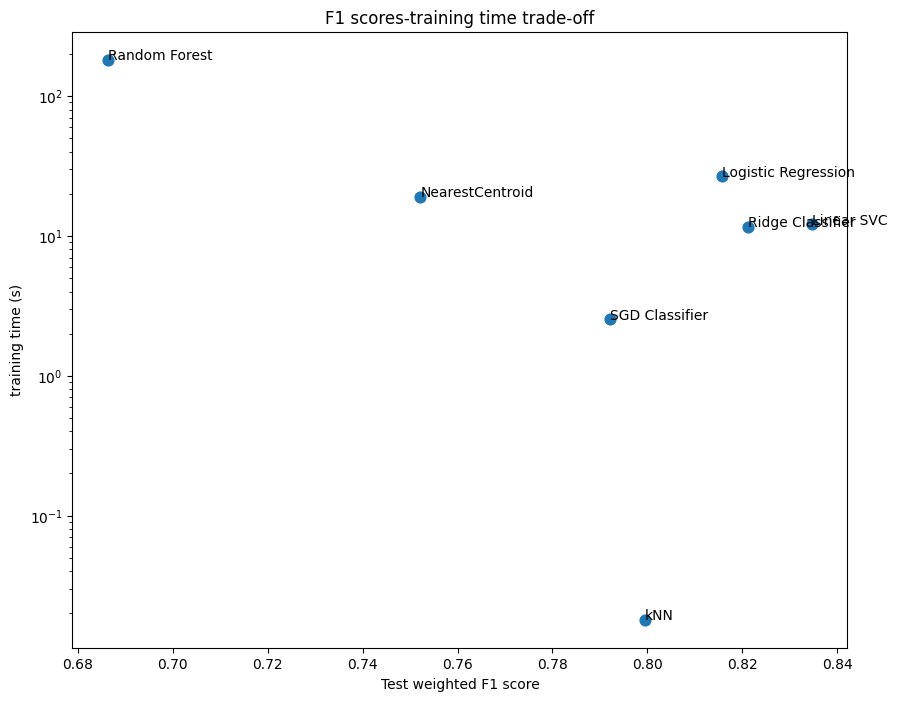

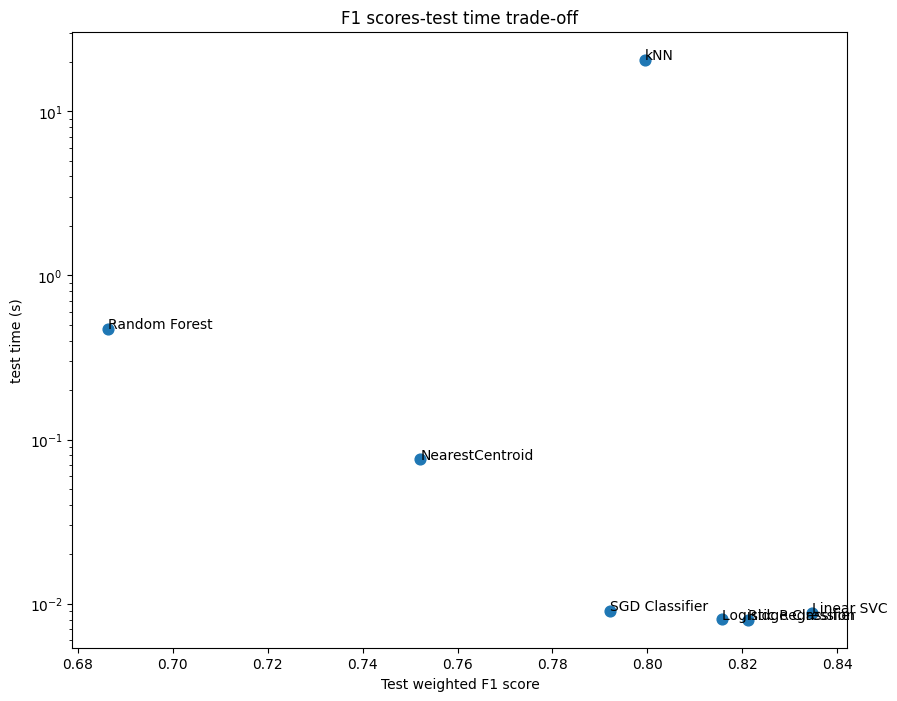

In [10]:
import numpy as np
import matplotlib.pyplot as plt  # Make sure matplotlib is imported

indices = np.arange(len(results))

# Extract all 5 elements from the results
results = [[x[i] for x in results] for i in range(4)]

# Unpack all 5 elements
clf_names, f1_scores, training_time, test_time = results
training_time = np.array(training_time)
test_time = np.array(test_time)

fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.scatter(f1_scores, training_time, s=60)
ax1.set(
    title="F1 scores-training time trade-off",
    yscale="log",
    xlabel="Test weighted F1 score",
    ylabel="training time (s)",
)

fig, ax2 = plt.subplots(figsize=(10, 8))
ax2.scatter(f1_scores, test_time, s=60)
ax2.set(
    title="F1 scores-test time trade-off",
    yscale="log",
    xlabel="Test weighted F1 score",
    ylabel="test time (s)",
)


# Add text annotations to all plots
for i, txt in enumerate(clf_names):
    ax1.annotate(txt, (f1_scores[i], training_time[i]))
    ax2.annotate(txt, (f1_scores[i], test_time[i]))


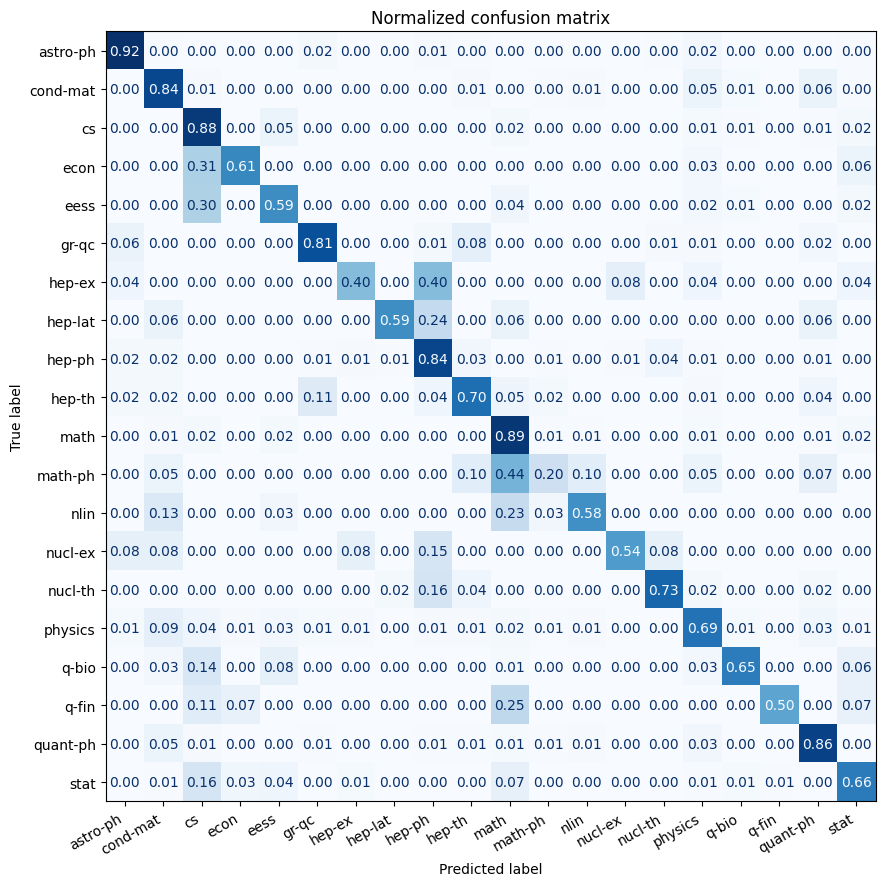

In [21]:
from src.utils import plot_confusion_matrix
from sklearn.metrics import classification_report

svm_clf = LinearSVC(random_state=42, class_weight="balanced")
svm_clf.fit(X_train, y_train)
y_preds = svm_clf.predict(X_valid)

plot_confusion_matrix(y_preds, y_valid, labels)


In [22]:
print(classification_report(y_valid, y_preds, target_names=labels))


              precision    recall  f1-score   support

    astro-ph       0.94      0.92      0.93       515
    cond-mat       0.83      0.84      0.83       546
          cs       0.93      0.88      0.91      3148
        econ       0.50      0.61      0.55        36
        eess       0.50      0.59      0.54       333
       gr-qc       0.76      0.81      0.78       137
      hep-ex       0.48      0.40      0.43        25
     hep-lat       0.67      0.59      0.62        17
      hep-ph       0.78      0.84      0.81       186
      hep-th       0.65      0.70      0.68       107
        math       0.88      0.89      0.89      1152
     math-ph       0.31      0.20      0.24        41
        nlin       0.41      0.58      0.48        31
     nucl-ex       0.70      0.54      0.61        13
     nucl-th       0.71      0.73      0.72        49
     physics       0.73      0.69      0.71       487
       q-bio       0.54      0.65      0.59        77
       q-fin       0.58    